In [24]:
import torch
from pathlib import Path
import json
from collections import defaultdict
from datetime import datetime, date
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# Need this if you want to save/load data into your drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title Authenticating gspread to write to sheets


# from google.colab import auth
# auth.authenticate_user()

# import gspread
# from gspread.models import Cell
# from oauth2client.client import GoogleCredentials

# gc = gspread.authorize(GoogleCredentials.get_application_default())
# sh = gc.open("NA Results")

In [6]:
# Adjust PATH as needed
PATH = Path('/content/gdrive/MyDrive/YouTube/Valorant Berlin')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [7]:
all_lines = {}

regions = ["EMEA", "KOREA", "NA", "LATAM", "SEA"]

for region in regions:
  # might need to adjust this to wherever you want to put the data
  with open(PATH / "datasets" / f"{region}_dataset.txt") as f:
    lines = f.readlines()
    lines = [[x.strip("][\n\'") for x in line.split(', ')] for line in lines]
    all_lines[region] = lines

for region, lines in all_lines.items():
  print(region, len(lines))

EMEA 1021
KOREA 594
NA 1790
LATAM 879
SEA 1032


In [9]:
#@title player map maps
PLAYER_COUNT_THRESH = 50

def get_player_map_maps(dataset):
  player_counts = defaultdict(int)
  maps = set()
  for region, dataset_lines in dataset.items():
    for line in dataset_lines:
      for player in line[8:18]:
        player_counts[player] += 1

      map_name = line[1]
      maps.add(map_name)

  maps = list(maps)

  all_players = []
  for player, count in player_counts.items():
    if count > PLAYER_COUNT_THRESH:
      all_players.append(player)

  print(len(all_players), len(maps))

  num_players = len(all_players)
  player_to_idx = {
      player: i for  i, player in enumerate(all_players)
  }

  idx_to_player = {
      i: player for i, player in enumerate(all_players)
  }

  map_to_idx = {
      map: i for i, map in enumerate(maps)
  }

  idx_to_map = {
      i: map for i, map in enumerate(maps)
  }

  return player_to_idx, idx_to_player, map_to_idx, idx_to_map


def load_player_map_maps():
  with open(PATH / "models" / "world_player_to_idx.json", "r") as f:
    player_to_idx = json.load(f)

  with open(PATH / "models" / "world_map_to_idx.json", "r") as f:
    map_to_idx = json.load(f)

  idx_to_player = {i: player for player, i in player_to_idx.items()}
  idx_to_map = {i: map for map, i in map_to_idx.items()}

  return player_to_idx, idx_to_player, map_to_idx, idx_to_map

In [10]:
# choose line based on if your getting fresh maps from dataset or loading existing
player_to_idx, idx_to_player, map_to_idx, idx_to_map = get_player_map_maps(all_lines)
# player_to_idx, idx_to_player, map_to_idx, idx_to_map = load_player_map_maps()
num_players = len(player_to_idx)
print(len(player_to_idx), len(map_to_idx))


283 6
283 6


In [11]:
# uncomment if you want to save the player maps

# import json
# with open(PATH / "models" / "world_player_to_idx.json", "w") as f:
#   json.dump(player_to_idx, f)

# with open(PATH / "models" / "world_map_to_idx.json", "w") as f:
#   json.dump(map_to_idx, f)

In [12]:
def parse_vec(vec):
  date = vec[0]
  map_name = vec[1]
  map_idx = map_to_idx[map_name]
  team1 = vec[2]
  team2 = vec[3]
  team1_abbrev = vec[4]
  team2_abbrev = vec[5]
  team1_rounds = int(vec[6])
  team2_rounds = int(vec[7])
  # assume predictions won't include OT so normalize
  rounds_mult = 13 / max(team1_rounds, team2_rounds)
  
  players = vec[8:18]
  player_idxs = [player_to_idx.get(p, num_players) for p in players]
  
  team1_rounds_norm = team1_rounds * rounds_mult
  team2_rounds_norm = team2_rounds * rounds_mult

  assists = [int(x) for x in vec[18:28]]
  acss = [int(x) for x in vec[28:38]]
  kds = [int(x) for x in vec[38:88]]

  assists_norm = [round(int(x) * rounds_mult) for x in assists]
  kds_norm = [round(int(x) * rounds_mult) for x in kds]

  return (
      map_idx, 
      player_idxs, 
      team1_rounds_norm, 
      team2_rounds_norm, 
      assists_norm, 
      acss, 
      kds_norm, 
      date, 
      team1, 
      team2,
      team1_abbrev,
      team2_abbrev,
      # team1_rounds,
      # team2_rounds,
      # assists,
      # kds,
  )

  

In [15]:
def augment_data(x, team_meta, label, num_augments = 10):
  x_aug = []
  team_meta_aug = []
  label_aug = []
  for n in range(num_augments):
    team_switch = torch.randperm(2)[0]
    players1_perm = torch.randperm(5)
    players2_perm = 5 + torch.randperm(5)
    if team_switch:
      perm = torch.cat((players2_perm, players1_perm))
    else:
      perm = torch.cat((players1_perm, players2_perm))
    
    new_x = torch.cat((x[perm], torch.as_tensor([x[10]])))
    new_label = {}
    if team_switch:
      new_label["team1_rounds"] = label["team2_rounds"]
      new_label["team2_rounds"] = label["team1_rounds"]
      new_team_meta = {
        "team1": team_meta["team2"], 
        "team1_abbrev": team_meta["team2_abbrev"],
        "team2": team_meta["team1"], 
        "team2_abbrev": team_meta["team1_abbrev"],
        "date": team_meta["date"]
      }
    else:
      new_label["team1_rounds"] = label["team1_rounds"]
      new_label["team2_rounds"] = label["team2_rounds"]
      new_team_meta = {
        "team1": team_meta["team1"], 
        "team1_abbrev": team_meta["team1_abbrev"],
        "team2": team_meta["team2"], 
        "team2_abbrev": team_meta["team2_abbrev"],
        "date": team_meta["date"]
      }

    new_label["assists"] = label["assists"][perm]
    new_label["acss"] = label["acss"][perm]
    new_label["kills_total"] = label["kills_total"][perm]
    new_label["deaths_total"] = label["deaths_total"][perm]

    new_encounters = []
    new_kills = []
    if not team_switch:
      for p1 in players1_perm:
        for p2 in players2_perm - 5:
          idx = p1 * 5 + p2 
          new_kills.append(label["kills"][idx].item())
          new_encounters.append(label["encounters"][idx].item())
    else:
      for p2 in players2_perm - 5:
        for p1 in players1_perm:
          idx = p1 * 5 + p2 
          new_kills.append((label["encounters"][idx] - label["kills"][idx]).item())
          new_encounters.append(label["encounters"][idx].item())

    new_label["kills"] = torch.as_tensor(new_kills)
    new_label["encounters"] = torch.as_tensor(new_encounters)
    
    x_aug.append(new_x)
    team_meta_aug.append(new_team_meta)
    label_aug.append(new_label)

  return x_aug, team_meta_aug, label_aug

In [16]:
NA_Challenger3_teams = [
  "Sentinels",
  "XSET",
  "100 Thieves",
  "Envy",
  "TSM", 
  "FaZe Clan",
  "Luminosity",
  "Rise"
]

BERLIN_TEAMS = {
  "Sentinels": "SEN",
  "100 Thieves" : "100T",
  "Envy": "NV",
  "Acend": "ACE",
  "Gambit Esports": "GAMBIT",
  "G2 Esports" : "G2",
  "SuperMassive Blaze": "SMB",
  "Vision Strikers": "VS",
  "F4Q": "F4Q",
  "Bren Esports": "BRN",
  "Paper Rex": "PRX",
  "Havan Liberty": "HL",
  "Vivo Keyd": "VIVO",
  "KRU Esports": "KRU",
  "Crazy Raccoon": "CR",
  "ZETA DIVISION": "ZETA",
}

In [17]:
# might need to upload this as well - in codebase under metadata/berlin_players.json
with open(PATH / "models" / "berlin_players.json") as f:
  BERLIN_TEAM_PLAYERS = json.load(f)

print(BERLIN_TEAM_PLAYERS)

{'Sentinels': [['TenZ', 67], ['zombs', 68], ['ShahZaM', 69], ['SicK', 70], ['dapr', 71]], '100 Thieves': [['Hiko', 128], ['Asuna', 129], ['nitr0', 130], ['Ethan', 126], ['steel', 127]], 'Envy': [['yay', 131], ['Marved', 132], ['FNS', 133], ['crashies', 134], ['Victor', 135]], 'Acend': [['cNed', 10], ['starxo', 11], ['zeek', 12], ['Kiles', 13], ['BONECOLD', 14]], 'Gambit Esports': [['sheydos', 5], ['nAts', 6], ['Redgar', 7], ['Chronicle', 8], ['d3ffo', 9]], 'G2 Esports': [['Mixwell', 15], ['keloqz', 16], ['nukkye', 17], ['koldamenta', 18], ['AvovA', 19]], 'SuperMassive Blaze': [['russ', 0], ['Izzy', 1], ['Brave', 2], ['Turko', 3], ['pAura', 4]], 'Vision Strikers': [['Lakia', 72], ['BuZz', 82], ['k1Ng', 83], ['Rb', 84], ['stax', 85], ['Other', 283]], 'F4Q': [['Bunny', 86], ['Esperanza', 87], ['fiveK', 88], ['Efina', 89], ['zunba', 90]], 'Bren Esports': [['BORKUM', 256], ['dispenser', 252], ['Witz', 253], ['DubsteP', 254], ['JessieVash', 255]], 'Paper Rex': [['shiba', 251], ['f0rsakeN', 2

In [19]:
X = []
team_meta = []
labels = []

val_X = []
val_team_meta = []
val_labels = []

na_challenger3_X = []
na_challenger3_team_meta = []
na_challenger3_labels = []

seen_maps = set()
maps_by_team = {team: defaultdict(int) for team in BERLIN_TEAMS}

for region, lines in all_lines.items():
  for line in lines:
    map_idx, player_idxs, team1_rounds, team2_rounds, assists, acss, kds, game_date_str, team1, team2, team1_abbrev, team2_abbrev = parse_vec(line)
    game_date = datetime.strptime(game_date_str, "%Y-%m-%d %H:%M:%S")

    if game_date < datetime(year=2021, month=3, day=1):
      continue

    map_name = idx_to_map[map_idx]

    map_rep = (game_date, map_idx, team1, team2)
    if map_rep in seen_maps:
      continue
    seen_maps.add(map_rep)
    
    if team1 in BERLIN_TEAMS:
      maps_by_team[team1][map_name] += 1
    if team2 in BERLIN_TEAMS:
      maps_by_team[team2][map_name] += 1


    x = torch.as_tensor(player_idxs + [map_idx])

    map_team_meta = {
      "team1": team1, 
      "team1_abbrev": team1_abbrev,
      "team2": team2, 
      "team2_abbrev": team2_abbrev,
      "date": game_date_str
    }
    
    encounters = []
    kills = []
    kills_total = [0 for _ in range(10)]
    deaths_total = [0 for _ in range(10)]
    try:
      for p1 in range(5):
        for p2 in range(5):
          start = p1 * 10 + p2 * 2
          encounters.append(kds[start] + kds[start + 1])
          kills.append(kds[start])
          kills_total[p1] += kds[start]
          kills_total[5 + p2] += kds[start+1]
          deaths_total[p1] += kds[start+1]
          deaths_total[5 + p2] += kds[start]
    except:
        print("Bad performance data for", map_rep)
        continue

    label = {
        "team1_rounds": team1_rounds,
        "team2_rounds": team2_rounds,
        "assists": torch.as_tensor(assists),
        "acss": torch.as_tensor(acss).float(),
        "encounters": torch.as_tensor(encounters),
        "kills": torch.as_tensor(kills),
        "kills_total": torch.as_tensor(kills_total),
        "deaths_total": torch.as_tensor(deaths_total)
    }

  # if game_date >= datetime(year=2021, month=8, day=11):
  #   val_X.append(x)
  #   val_team_meta.append(map_team_meta)
  #   val_labels.append(label)
  #   if (game_date < datetime(year=2021, month=8, day=16) 
  #       and team1 in NA_Challenger3_teams 
  #       and team2 in NA_Challenger3_teams):
  #     na_challenger3_X.append(x)
  #     na_challenger3_team_meta.append(map_team_meta)
  #     na_challenger3_labels.append(label)
   
  # else:
    
    # Currently training on full dataset for berlin - uncomment above to 
    # setup for NA Challengers 3 setup
    X.append(x)
    team_meta.append(map_team_meta)
    labels.append(label)
    try:
      x_aug, team_meta_aug, label_aug = augment_data(x, map_team_meta, label)
      X.extend(x_aug)
      team_meta.extend(team_meta_aug)
      labels.extend(label_aug) 
    except:
      print("Can't aug", x)

print(len(X), len(team_meta), len(labels))
print(len(labels), len(val_labels), len(na_challenger3_labels))

Bad performance data for (datetime.datetime(2021, 6, 16, 8, 30), 2, 'Alter Ego', 'Art of Throwing')
Bad performance data for (datetime.datetime(2021, 6, 16, 8, 30), 3, 'Alter Ego', 'Art of Throwing')
35046 35046 35046
35046 0 0


In [20]:
#@title Torch Dataset Setup
from torch.utils.data import Dataset, DataLoader

class ValorantDataset(Dataset):
  def __init__(self, X, team_meta, labels):
    self.X = X
    self.team_meta = team_meta
    self.labels = labels
  
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return (
        self.X[idx], 
        self.team_meta[idx],
        self.labels[idx]
    )

traindata = ValorantDataset(X, team_meta, labels)
valdata = ValorantDataset(val_X, val_team_meta, val_labels)
na_challenger3_data = ValorantDataset(na_challenger3_X, na_challenger3_team_meta, na_challenger3_labels)

In [21]:
batch_size = 64
trainloader = DataLoader(traindata, batch_size=batch_size)
valloader = None
# valloader = DataLoader(valdata, batch_size=batch_size, shuffle=False)
# na_challenger3_loader = DataLoader(na_challenger3_data, batch_size=10, shuffle=False)

In [22]:
#@title Data Validation

all_mins = {}
all_maxes = {}
for batch_idx, batch_data in enumerate(trainloader):
  for key, val in batch_data[2].items():
    if key in all_mins:
      all_mins[key] = min(val.min().item(), all_mins[key])
      all_maxes[key] = max(val.max().item(), all_maxes[key])
    else:
      all_mins[key] = val.min().item()
      all_maxes[key] = val.max().item()

print(all_mins)
print(all_maxes)

{'team1_rounds': 0.0, 'team2_rounds': 0.0, 'assists': 0, 'acss': 11.0, 'encounters': 0, 'kills': 0, 'kills_total': 0, 'deaths_total': 0}
{'team1_rounds': 13.0, 'team2_rounds': 13.0, 'assists': 22, 'acss': 586.0, 'encounters': 17, 'kills': 12, 'kills_total': 37, 'deaths_total': 25}


In [ ]:
#@title First Model
from torch import nn
from torch import distributions as ds

class ValModelOld(nn.Module):
  def __init__(
      self, 
      players_map, 
      maps_map,
      players, 
      maps,
      player_embedding_size, 
      map_embedding_size,
      hidden_size1,
      hidden_size2,
      assist_lambd=0.125,
      acs_lambd=0.0005,
      kd_lambd=0.25,
      rounds_lambd=1
    ):
    super().__init__()

    self.players_map = players_map
    self.maps_map = maps_map
    self.players = players
    self.maps = maps
    
    # +1 for "other"
    self.num_players = len(players_map) + 1
    self.num_maps = len(maps_map)
    self.player_embedding_size = player_embedding_size
    self.map_embedding_size = map_embedding_size
    self.hidden_size1 = hidden_size1
    self.hidden_size2 = hidden_size2

    self.assist_lambd = assist_lambd
    self.acs_lambd = acs_lambd
    self.kd_lambd = kd_lambd
    self.rounds_lambd = rounds_lambd

    self.player_embeddings = nn.Embedding(self.num_players, self.player_embedding_size)
    self.map_embeddings = nn.Embedding(self.num_maps, self.map_embedding_size)

    self.mlp = nn.Sequential(
        nn.Linear(10 * self.player_embedding_size + self.map_embedding_size, hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU()
    )

    self.dropout = nn.Dropout(0.4)

    self.assist_out = nn.Linear(self.hidden_size2, 10)
    self.acs_out = nn.Linear(self.hidden_size2, 10)
    self.kd_out = nn.Linear(self.hidden_size2, 50)
    self.rounds_out = nn.Linear(self.hidden_size2, 2)
    # self.rounds_out = nn.Sequential(
    #     nn.Linear(self.hidden_size2, 2),
    #     nn.Softmax()
    # )

  def forward(self, X):
    batch_size = X.shape[0]
    player_embs = self.player_embeddings(X[:, :10]).view(batch_size, -1)
    map_embs = self.map_embeddings(X[:, 10])
    
    mlp_input = torch.cat((player_embs, map_embs), dim=1)
    mlp_input = self.dropout(mlp_input)
    
    mlp_out = self.mlp(mlp_input)
    mlp_out = self.dropout(mlp_out)
    
    assists = self.assist_out(mlp_out)
    acss = self.acs_out(mlp_out)
    kds = self.kd_out(mlp_out)
    rounds = self.rounds_out(mlp_out)


    return [assists, acss, kds, rounds]

  def calc_loss(self, model_out, truths, verbose=False):
    model_assists, model_acss, model_kds, model_rounds = model_out
    truth_team1_rounds = truths[0]
    truth_team2_rounds = truths[1]
    # truth_tot_rounds = truth_team1_rounds + truth_team2_rounds
    # truth_team1_rounds_ratio = truth_team1_rounds / truth_tot_rounds
    # truth_team2_rounds_ratio = truth_team2_rounds / truth_tot_rounds
    truth_assists = truths[2]
    truth_acss = truths[3]
    truth_kds = truths[4]

    assist_loss = ((model_assists - truth_assists) ** 2).sum()
    acs_loss = ((model_acss - truth_acss) ** 2).sum()
    kd_loss = ((model_kds - truth_kds) ** 2).sum()
    rounds_loss = (
        ((model_rounds[:, 0] - truth_team1_rounds) ** 2).sum() + 
        ((model_rounds[:, 1] - truth_team2_rounds) ** 2).sum()
    )
    
    if verbose:
      print("assist loss: ",  self.assist_lambd * assist_loss)
      print("acs loss: ", self.acs_lambd * acs_loss)
      print("kd loss: ", self.kd_lambd * kd_loss)
      print("rounds loss: ", self.rounds_lambd * rounds_loss)

    loss = (
        self.assist_lambd * assist_loss + 
        self.acs_lambd * acs_loss + 
        self.kd_lambd * kd_loss + 
        self.rounds_lambd * rounds_loss
    )

    return loss


In [ ]:
#@title Stats Model Second
class ValStatsModelOld(nn.Module):
  def __init__(
      self, 
      players_map, 
      maps_map,
      players, 
      maps,
      player_embedding_size, 
      map_embedding_size,
      hidden_size1,
      hidden_size2,
      assist_lambd=1,
      acs_lambd=0.001,
      kdp_lambd=1,
      encounter_lambd=1,
      rounds_lambd=2
    ):
    super().__init__()

    self.players_map = players_map
    self.maps_map = maps_map
    self.players = players
    self.maps = maps
    
    # +1 for "other"
    self.num_players = len(players_map) + 1
    self.num_maps = len(maps_map)
    self.player_embedding_size = player_embedding_size
    self.map_embedding_size = map_embedding_size
    self.hidden_size1 = hidden_size1
    self.hidden_size2 = hidden_size2

    self.assist_lambd = assist_lambd
    self.acs_lambd = acs_lambd
    self.kdp_lambd = kdp_lambd
    self.encounter_lambd = encounter_lambd
    self.rounds_lambd = rounds_lambd

    self.player_embeddings = nn.Embedding(self.num_players, self.player_embedding_size)
    self.map_embeddings = nn.Embedding(self.num_maps, self.map_embedding_size)

    self.interaction = nn.Sequential(
        nn.Linear(10 * self.player_embedding_size + self.map_embedding_size, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU()
    )

    self.dropout = nn.Dropout(0.4)

    self.encounter_mlp = nn.Sequential(
        nn.Linear(2 * self.player_embedding_size + self.map_embedding_size + self.hidden_size2, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU(),
        nn.Linear(self.hidden_size2, 1)
    )

    self.kdp_mlp = nn.Sequential(
        nn.Linear(2 * self.player_embedding_size + self.map_embedding_size + self.hidden_size2, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU(),
        nn.Linear(self.hidden_size2, 1),
        nn.Sigmoid()
    )

    self.assists_mlp = nn.Sequential(
        nn.Linear(self.player_embedding_size + self.map_embedding_size + self.hidden_size2, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU(),
        nn.Linear(self.hidden_size2, 1)
    )
    
    self.acss_mlp = nn.Sequential(
        nn.Linear(3 + self.player_embedding_size + self.map_embedding_size, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU(),
        nn.Linear(self.hidden_size2, 1)
    )


  def kd_assists_forward(self, X):
    batch_size = X.shape[0]
    player_embs = self.player_embeddings(X[:, :10])
    map_emb = self.map_embeddings(X[:, 10])

    interaction_input = torch.cat((player_embs.view(batch_size, -1), map_emb), dim=1)
    interaction_input = self.dropout(interaction_input)
    
    interaction_out = self.interaction(interaction_input)
    interaction_out = self.dropout(interaction_out)
    
    kd_input = []
    for t1 in range(5):
      for t2 in range(5, 10):
        kd_input.append(
            torch.cat(
                (player_embs[:, t1], 
                 player_embs[:, t2], 
                 map_emb, 
                 interaction_out), 
                 dim=1
            )
        )

    kd_input = torch.stack(kd_input)
    _, batch_size, kd_input_size = kd_input.shape
    kd_input = kd_input.view(-1, kd_input_size)
    kd_input = self.dropout(kd_input)

    encounters = self.encounter_mlp(kd_input).view(25, batch_size, -1)
    encounters = encounters.squeeze(dim=2).transpose(0,1)
    encounters = torch.exp(encounters)
    
    kdps = self.kdp_mlp(kd_input).view(25, batch_size, -1)
    kdps = kdps.squeeze(dim=2).transpose(0,1)

    assists_input = []
    acss_input = []
    for i in range(player_embs.shape[1]):
        assists_input.append(
            torch.cat(
                (player_embs[:, i],
                 map_emb, 
                 interaction_out), 
                 dim=1
            )
        )        
    
    assists_input = torch.stack(assists_input)
    _, batch_size, assists_input_size = assists_input.shape
    assists_input = assists_input.view(-1, assists_input_size)
    assists_input = self.dropout(assists_input)

    assists = self.assists_mlp(assists_input).view(10, batch_size, -1)
    assists = assists.squeeze(dim=2).transpose(0,1)
    assists = torch.exp(assists)

    return [assists, encounters, kdps]

  def acs_forward(self, X, kills, deaths, assists):
    batch_size = X.shape[0]
    player_embs = self.player_embeddings(X[:, :10])
    map_emb = self.map_embeddings(X[:, 10])

    acss_input = []
    for i in range(player_embs.shape[1]):
      acss_input.append(
          torch.cat(
              (kills[:, i].unsqueeze(1), 
               deaths[:, i].unsqueeze(1), 
               assists[:, i].unsqueeze(1),
               player_embs[:, i], 
               map_emb), dim=1)
      )

    acss_input = torch.stack(acss_input)
    _, batch_size, acss_input_size = acss_input.shape
    acss_input = acss_input.view(-1, acss_input_size)
    # acss_input = self.dropout(acss_input)

    acss = self.acss_mlp(acss_input).view(10, batch_size, -1)
    acss = acss.squeeze(dim=2).transpose(0,1)

    return acss

  def calc_loss(self, model_out, truths, verbose=False):
    model_assists, model_encounters, model_kdps, model_acss = model_out

    truth_assists = truths[2]
    truth_acss = truths[3]
    truth_encounters = truths[4]
    truth_kills = truths[5]

    assist_ds = ds.Poisson(model_assists)
    assist_loss = -1 * assist_ds.log_prob(truth_assists).sum()

    encounter_ds = ds.Poisson(model_encounters)
    encounter_loss = -1 * encounter_ds.log_prob(truth_encounters).sum()

    kdp_ds = ds.Binomial(truth_encounters, probs=model_kdps)
    kdp_loss = -1 * kdp_ds.log_prob(truth_kills).sum()

    acs_loss = ((model_acss - truth_acss) ** 2).sum()

    assist_loss = self.assist_lambd * assist_loss
    acs_loss = self.acs_lambd * acs_loss
    kdp_loss = self.kdp_lambd * kdp_loss
    encounter_loss = self.encounter_lambd * encounter_loss

    if verbose:
      print("assist loss: ", assist_loss.item())
      print("acs loss: ", acs_loss.item())
      print("kdp loss: ", kdp_loss.item())
      print("encounter loss: ",encounter_loss.item())

    loss = assist_loss + acs_loss + kdp_loss + encounter_loss

    return [loss, assist_loss, acs_loss, kdp_loss, encounter_loss]

In [25]:
class ValStatsModel(nn.Module):
  def __init__(
      self, 
      players_map, 
      maps_map,
      players, 
      maps,
      player_embedding_size, 
      map_embedding_size,
      hidden_size1,
      hidden_size2,
      closeness_lambd=3,
      assist_lambd=1,
      acs_lambd=0.001,
      kdp_lambd=1,
      encounter_lambd=1,
      rounds_lambd=2
    ):
    super().__init__()

    self.players_map = players_map
    self.maps_map = maps_map
    self.players = players
    self.maps = maps
    
    # +1 for "other"
    self.num_players = len(players_map) + 1
    self.num_maps = len(maps_map)
    self.player_embedding_size = player_embedding_size
    self.map_embedding_size = map_embedding_size
    self.hidden_size1 = hidden_size1
    self.hidden_size2 = hidden_size2

    self.assist_lambd = assist_lambd
    self.acs_lambd = acs_lambd
    self.kdp_lambd = kdp_lambd
    self.encounter_lambd = encounter_lambd
    self.rounds_lambd = rounds_lambd

    self.player_embeddings = nn.Embedding(self.num_players, self.player_embedding_size)
    self.map_embeddings = nn.Embedding(self.num_maps, self.map_embedding_size)

    self.rounds_prior_mlp = nn.Sequential(
        nn.Linear(10 * self.player_embedding_size + self.map_embedding_size, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU(),
        nn.Linear(self.hidden_size2, 4),
    )

    self.dropout = nn.Dropout(0.4)

    self.encounter_mlp = nn.Sequential(
        nn.Linear(2 * self.player_embedding_size + self.map_embedding_size, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU(),
        nn.Linear(self.hidden_size2, 2)
    )

    self.kdp_mlp1 = nn.Sequential(
        nn.Linear(2 * self.player_embedding_size + self.map_embedding_size, 4),
    )
    self.kdp_mlp2 = nn.Sequential(
        nn.Linear(2 + 4, self.hidden_size2),
        nn.ReLU(),
        nn.Linear(self.hidden_size2, 1),
        nn.Sigmoid()
    )

    self.assists_mlp = nn.Sequential(
        nn.Linear(self.player_embedding_size + self.map_embedding_size, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU(),
        nn.Linear(self.hidden_size2, 1)
    )
    
    self.acss_mlp = nn.Sequential(
        nn.Linear(3 + self.player_embedding_size + self.map_embedding_size, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU(),
        nn.Linear(self.hidden_size2, 1)
    )


  def rounds_prior_forward(self, X):
    batch_size = X.shape[0]
    player_embs = self.player_embeddings(X[:, :10])
    map_emb = self.map_embeddings(X[:, 10])

    rounds_prior_input = torch.cat((player_embs.view(batch_size, -1), map_emb), dim=1)
    rounds_prior_input = self.dropout(rounds_prior_input)
    rounds_prior = self.rounds_prior_mlp(rounds_prior_input)
    rounds_prior = torch.exp(rounds_prior)

    return rounds_prior
  

  def kd_assists_forward(self, X, team1_rounds, team2_rounds):
    batch_size = X.shape[0]
    player_embs = self.player_embeddings(X[:, :10])
    map_emb = self.map_embeddings(X[:, 10])

    kd_input = []
    for t1 in range(5):
      for t2 in range(5, 10):
        kd_input.append(
            torch.cat(
                (player_embs[:, t1], 
                 player_embs[:, t2], 
                 map_emb), 
                 dim=1
            )
        )

    kd_input = torch.stack(kd_input)
    _, batch_size, kd_input_size = kd_input.shape
    kd_input = kd_input.view(-1, kd_input_size)
    kd_input = self.dropout(kd_input)

    encounters = self.encounter_mlp(kd_input).view(25, batch_size, -1)
    encounters = encounters.squeeze(dim=2).transpose(0,1)
    encounters = torch.exp(encounters)
    
    kdp1_out = self.kdp_mlp1(kd_input) 
    kdp2_input = torch.cat(
       (team1_rounds.repeat(25).unsqueeze(1), 
        team2_rounds.repeat(25).unsqueeze(1), 
        kdp1_out), 
        dim=1
    )
    kdps = self.kdp_mlp2(kdp2_input)
    kdps = kdps.view(25, batch_size, -1).squeeze(dim=2).transpose(0,1)

    assists_input = []
    for i in range(player_embs.shape[1]):
        assists_input.append(
            torch.cat(
                (player_embs[:, i],
                 map_emb), 
                 dim=1
            )
        )        
    
    assists_input = torch.stack(assists_input)
    _, batch_size, assists_input_size = assists_input.shape
    assists_input = assists_input.view(-1, assists_input_size)
    assists_input = self.dropout(assists_input)

    assists = self.assists_mlp(assists_input).view(10, batch_size, -1)
    assists = assists.squeeze(dim=2).transpose(0,1)
    assists = torch.exp(assists)

    return [assists, encounters, kdps]

  def acs_forward(self, X, kills, deaths, assists):
    batch_size = X.shape[0]
    player_embs = self.player_embeddings(X[:, :10])
    map_emb = self.map_embeddings(X[:, 10])

    acss_input = []
    for i in range(player_embs.shape[1]):
      acss_input.append(
          torch.cat(
              (kills[:, i].unsqueeze(1), 
               deaths[:, i].unsqueeze(1), 
               assists[:, i].unsqueeze(1),
               player_embs[:, i], 
               map_emb), dim=1)
      )

    acss_input = torch.stack(acss_input)
    _, batch_size, acss_input_size = acss_input.shape
    acss_input = acss_input.view(-1, acss_input_size)
    # acss_input = self.dropout(acss_input)

    acss = self.acss_mlp(acss_input).view(10, batch_size, -1)
    acss = acss.squeeze(dim=2).transpose(0,1)

    return acss

  def calc_loss(self, model_out, labels, verbose=False):   
    model_rounds_prior, model_assists, model_encounters, model_kdps, model_acss = model_out
    
    model_rounds1_means = model_rounds_prior[:, 0]
    model_rounds1_stds = model_rounds_prior[:, 1]
    model_rounds2_means = model_rounds_prior[:, 2]
    model_rounds2_stds = model_rounds_prior[:, 3]
    model_encounter_freqs = model_encounters[:, :, 0]
    model_encounter_stds = model_encounters[:, :, 1]

    truth_team1_rounds = labels["team1_rounds"]
    truth_team2_rounds = labels["team2_rounds"]
    truth_rounds = truth_team1_rounds + truth_team2_rounds
    truth_assists = labels["assists"]
    truth_acss = labels["acss"]
    truth_encounters = labels["encounters"]
    truth_kills = labels["kills"]

    rounds1_prior_ds = ds.Normal(model_rounds1_means, model_rounds1_stds)
    rounds1_loss = -1 * rounds1_prior_ds.log_prob(truth_team1_rounds).sum()
    rounds2_prior_ds = ds.Normal(model_rounds2_means, model_rounds2_stds)
    rounds2_loss = -1 * rounds2_prior_ds.log_prob(truth_team2_rounds).sum()

    assist_ds = ds.Poisson(model_assists)
    assist_loss = -1 * assist_ds.log_prob(truth_assists).sum()

    encounter_ds = ds.Normal(model_encounter_freqs * truth_rounds.unsqueeze(1), model_encounter_stds)
    encounter_loss = -1 * encounter_ds.log_prob(truth_encounters).sum()

    kdp_ds = ds.Binomial(truth_encounters, probs=model_kdps)
    kdp_loss = -1 * kdp_ds.log_prob(truth_kills).sum()

    acs_loss = ((model_acss - truth_acss) ** 2).sum()

    
    rounds_prior_loss = self.rounds_lambd * (rounds1_loss + rounds2_loss)
    assist_loss = self.assist_lambd * assist_loss
    acs_loss = self.acs_lambd * acs_loss
    kdp_loss = self.kdp_lambd * kdp_loss
    encounter_loss = self.encounter_lambd * encounter_loss

    if verbose:
      print("rounds loss: ", rounds_prior_loss.item())
      print("assist loss: ", assist_loss.item())
      print("acs loss: ", acs_loss.item())
      print("kdp loss: ", kdp_loss.item())
      print("encounter loss: ",encounter_loss.item())

    loss = rounds_prior_loss + assist_loss + acs_loss + kdp_loss + encounter_loss

    return [loss, rounds_prior_loss, assist_loss, acs_loss, kdp_loss, encounter_loss]

In [ ]:
#@title Rounds Model

# Not used anymore - was used when predicting rounds from 
# upstream stats like kd/assists/acs (now its flipped)
class ValRoundsModel(nn.Module):
  def __init__(self, hidden_size1, hidden_size2):
    super().__init__()

    self.hidden_size1 = hidden_size1
    self.hidden_size2 = hidden_size2
    
    self.team1_mlp = nn.Sequential(
        nn.Linear(20, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU(),
    )
    self.team2_mlp = nn.Sequential(
        nn.Linear(20, self.hidden_size1),
        nn.ReLU(),
        nn.Linear(self.hidden_size1, self.hidden_size2),
        nn.ReLU(),
    )

    self.final_out = nn.Sequential(
        nn.Linear(1 + self.hidden_size2 * 2, 2),
        nn.Softmax(dim=1)
    )

    self.dropout = nn.Dropout(0.25)
    

  def rounds_forward(self, kills, deaths, assists, acss, tot_rounds):
    team1_input = torch.cat((kills[:, :5], deaths[:, :5], assists[:, :5], acss[:, :5]), dim=1)
    team2_input = torch.cat((kills[:, 5:], deaths[:, 5:], assists[:, 5:], acss[:, 5:]), dim=1)
    team1_input = self.dropout(team1_input)
    team2_input = self.dropout(team2_input)

    team1_out = self.team1_mlp(team1_input)
    team2_out = self.team2_mlp(team2_input)
    team1_out = self.dropout(team1_out)
    team2_out = self.dropout(team2_out)

    rounds_out = self.final_out(torch.cat((tot_rounds.unsqueeze(1), team1_out, team2_out), dim=1))
    return rounds_out

  def calc_loss(self, model_rounds, truth_team1_rounds, truth_team2_rounds, verbose):
    model_rounds_multiplier = 13 / torch.max(model_rounds, dim=1)[0] 
    model_rounds_count = model_rounds * model_rounds_multiplier.unsqueeze(1)
    rounds_loss = (
        ((truth_team1_rounds - model_rounds_count[:, 0]) ** 2).sum() + 
        ((truth_team2_rounds - model_rounds_count[:, 1]) ** 2).sum()
    )

    if verbose:
      print("Rounds loss: ", rounds_loss.item())
    
    return rounds_loss

In [26]:
def batch_forward(stats_model, X, labels):
  tot_kills = labels["kills_total"]
  tot_deaths = labels["deaths_total"]
  assists = labels["assists"]
  acss = labels["acss"]
  team1_rounds = labels["team1_rounds"].float()
  team2_rounds = labels["team2_rounds"].float()
  truth_tot_rounds = team1_rounds + team2_rounds

  model_rounds_prior = stats_model.rounds_prior_forward(X)
  model_assists, model_encounters, model_kdps = stats_model.kd_assists_forward(X, team1_rounds, team2_rounds)
  model_acss = stats_model.acs_forward(X, tot_kills, tot_deaths, assists)

  model_out = [model_rounds_prior, model_assists, model_encounters, model_kdps, model_acss]

  return model_out

In [27]:
def validate(stats_model, valloader, verbose=False):
  with torch.no_grad():
    stats_model.eval()
    # overall, rounds, assists, acs, kdp, encounter
    val_loss = [0 for i in range(7)]
    num_datapoints = 0
    round_loss_tot = 0
    for batch_idx, (batch_X, batch_team_meta, batch_labels) in enumerate(valloader):
      
      X = batch_X.to(device)
      labels = {key: label.to(device) for key, label in batch_labels.items()}
      
      stats_out = batch_forward(stats_model, X, labels)
      stats_loss = stats_model.calc_loss(stats_out, labels, verbose)
      
      num_datapoints += X.shape[0]

      for i, loss in enumerate(stats_loss):
        val_loss[i] += loss.detach().item()
        
    val_loss = [x / num_datapoints for x in val_loss]
    print("Val loss:", sum(val_loss))
    stats_model.train()

    return val_loss

In [28]:
def get_kd_stats(pw_encounters, pw_kills):
  pairwise_kds = []
  tot_kills = [0 for i in range(10)]
  tot_deaths = [0 for i in range(10)]
  for i in range(25):
    t1 = i // 5
    t2 = i % 5
    encs = int(pw_encounters[i].item())
    kills = int(pw_kills[i].item())
    tot_kills[t1] += kills
    tot_deaths[t1] += encs - kills
    tot_kills[t2+5] += encs - kills
    tot_deaths[t2+5] += kills
    pairwise_kds.append([kills, encs-kills])

  return pairwise_kds, tot_kills, tot_deaths

# expects 1D map_X input
def sample_output(map_X, team_meta, stats_model, num_samples=1, write_info=None):
  X = map_X.unsqueeze(0)
  model_rounds_prior = stats_model.rounds_prior_forward(X)

  model_rounds1_mean = model_rounds_prior[:, 0].squeeze()
  model_rounds1_stds = model_rounds_prior[:, 1].squeeze()
  model_rounds2_mean = model_rounds_prior[:, 2].squeeze()
  model_rounds2_stds = model_rounds_prior[:, 3].squeeze()

  # print(model_rounds1_mean, model_rounds1_stds)
  # print(model_rounds2_mean, model_rounds2_stds)
  rounds1_prior_ds = ds.Normal(model_rounds1_mean, model_rounds1_stds)
  rounds1_ex = torch.clamp(rounds1_prior_ds.sample([num_samples]), min=0)
  rounds2_prior_ds = ds.Normal(model_rounds2_mean, model_rounds2_stds)
  rounds2_ex = torch.clamp(rounds2_prior_ds.sample([num_samples]), min=0)
  
  rounds_ex = torch.cat((rounds1_ex.unsqueeze(1), rounds2_ex.unsqueeze(1)), dim=1)
  rounds_multiplier = 13 / torch.max(rounds_ex, dim=1)[0]
  rounds1_ex = (rounds1_ex * rounds_multiplier + 0.01).int()
  rounds2_ex = (rounds2_ex * rounds_multiplier + 0.01).int()
  
  rounds_prior_means = [model_rounds1_mean.item(), model_rounds2_mean.item()]
  rounds_prior_ex = torch.cat((rounds1_ex.unsqueeze(1), rounds2_ex.unsqueeze(1)), dim=1)
  # print(rounds1_ex)
  # print(rounds2_ex)
  
  assists, encounters, kdps = stats_model.kd_assists_forward(X.repeat(num_samples, 1), rounds1_ex, rounds2_ex)

  assists_ds = ds.Poisson(assists)
  assists_ex = assists_ds.sample()

  encounter_freqs = encounters[:, :, 0]
  encounter_stds = encounters[:, :, 1]
  encounter_means = (encounter_freqs * (rounds1_ex + rounds2_ex).unsqueeze(1))
  
  encounters_ds = ds.Normal(encounter_means, encounter_stds)
  encounters_ex = encounters_ds.sample().int()
  encounters_ex = torch.clamp(encounters_ex, min=0)
  # print(encounters_ex)
  # print(kdps)

  kills_ds = ds.Binomial(encounters_ex, probs=kdps)
  kills_ex = kills_ds.sample()

  pairwise_kds = []
  tot_kills = [[0 for _ in range(10)] for _ in range(num_samples)]
  tot_deaths = [[0 for _ in range(10)] for _ in range(num_samples)]
  for n in range(num_samples):
    game_kds, game_tot_kills, game_tot_deaths = get_kd_stats(encounters_ex[n], kills_ex[n])
    pairwise_kds.append(game_kds)
    tot_kills[n] = game_tot_kills
    tot_deaths[n] = game_tot_deaths

  pairwise_kds = torch.as_tensor(pairwise_kds)
  tot_kills_inp = torch.as_tensor(tot_kills).float()
  tot_deaths_inp = torch.as_tensor(tot_deaths).float()

  stacked_X = map_X.repeat(num_samples, 1)

  acss = stats_model.acs_forward(stacked_X, tot_kills_inp, tot_deaths_inp, assists_ex)
  # rounds_out = rounds_model.rounds_forward(tot_kills_inp, tot_deaths_inp, assists_ex, acss.float(), rounds1_ex + rounds2_ex)
  # rounds_multiplier = 13 / torch.max(rounds_out, dim=1)[0] 
  # rounds_count = rounds_out * rounds_multiplier.unsqueeze(1)

  map_name = stats_model.maps[map_X[10].item()]
  players = [stats_model.players.get(p.item(), "Other") for p in map_X[:10]]
  print_preds(map_X, team_meta, tot_kills_inp, tot_deaths_inp, pairwise_kds, assists_ex, acss, rounds_prior_means, rounds_prior_ex, map_name, players, write_info)
  return 
       

def print_preds(X, team_meta, tot_kills, tot_deaths, pairwise_kds, assists, acss, rounds_exp, rounds, map_name, players, write_info):
  
  def print_pairs(game_pairwise_kds, players):   
    for i in range(25):
      t1 = i // 5
      t2 = i % 5
      print(f"{players[t1]} vs {players[5+t2]}: {game_pairwise_kds[i][0]}-{game_pairwise_kds[0][i][1]}")
 
  print(f"Map: {map_name}")
  # print_pairs(pairwise_kds, players)

  avg_rounds = rounds.float().mean(dim=0).int().tolist()
  avg_acss = acss.mean(dim=0).int().tolist()
  avg_assists = assists.mean(dim=0).int().tolist()
  avg_tot_kills = tot_kills.mean(dim=0).int().tolist()
  avg_tot_deaths = tot_deaths.mean(dim=0).int().tolist()
  avg_pairwise_kds = pairwise_kds.float().mean(dim=0).int().tolist()
  # print("MAP OVERALL RESULTS =============")
  # print(f"Rounds Exp: {rounds_exp[0]}-{rounds_exp[1]}")
  # print(f"Rounds: {avg_rounds[0]}-{avg_rounds[1]}")
  # for j, player in enumerate(players):
  #   print(f"{player}: ACS {round(avg_acss[j])} {round(avg_tot_kills[j])}-{round(avg_tot_deaths[j])}-{round(avg_assists[j])}")
  # print()

  if write_info is not None:
    write_game_sheets(
        write_info["game_desc"], map_name, team_meta["team1"], team_meta["team2"], team_meta["team1_abbrev"], team_meta["team2_abbrev"],
        avg_rounds, rounds_exp, players, avg_acss, avg_tot_kills, avg_tot_deaths, avg_assists, avg_pairwise_kds, 
        write_info["x_idx"], write_info["y_idx"]
    )


In [ ]:
def train_model(stats_model, num_epochs, trainloader, valloader, lr):
  stats_opt = torch.optim.Adam(stats_model.parameters(), lr=lr)

  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):
    # tot, rounds, assist, acs, kdp, encounter
    epoch_loss = [0 for i in range(6)]
    num_datapoints = 0
    
    rounds_zero_count = 0
    for batch_idx, (batch_X, batch_team_meta, batch_labels) in enumerate(trainloader):
      verbose = batch_idx % 100 == 0
      stats_opt.zero_grad()

      X = batch_X.to(device)
      labels = {key: label.to(device) for key, label in batch_labels.items()}
      
      stats_out = batch_forward(stats_model, X, labels)
      stats_loss = stats_model.calc_loss(stats_out, labels, verbose)
    
      if verbose:
        print(f"Epoch {epoch}, batch_idx: {batch_idx}")
        print()


      for i, loss in enumerate(stats_loss):
        epoch_loss[i] += loss.detach()
      num_datapoints += X.shape[0]

      stats_loss[0].backward()
      stats_opt.step()
      
    epoch_loss = [x / num_datapoints for x in epoch_loss]
    print(f"Epoch {epoch}, Loss: {sum(epoch_loss)}")
    if valloader is not None:
      val_loss = validate(stats_model, valloader, False)
      train_losses.append(epoch_loss)
      val_losses.append(val_loss)

    print(f"{'=' * 50}\n")
  return train_losses, val_losses





In [ ]:
stats_model = ValStatsModel(
    player_to_idx,
    map_to_idx,
    idx_to_player,
    idx_to_map,
    10,
    10,
    24, 
    12,
)
stats_model.to(device)

# train_losses, val_losses = train_model(stats_model, 70, trainloader, valloader, 0.003)
model_path = f"{PATH}/models/berlin_65epochs.pt"
state_dict = torch.load(model_path)
stats_model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# model_path = f"{PATH}/models/berlin_65epochs.pt"
# torch.save(stats_model.state_dict(), model_path)

In [ ]:
validate(stats_model, valloader, True)

In [ ]:
#@title Write results to sheets

def write_game_sheets(
    game_desc, map_name, team1, team2, team1_abbrev, team2_abbrev,
    rounds, rounds_exp, players, acss, tot_kills, tot_deaths, assists, pairwise_kds, 
    start_x_idx=1, start_y_idx=1
  ):

  worksheets = [x.title for x in sh.worksheets()]
  print(worksheets)
  if game_desc in worksheets:
    worksheet = sh.worksheet(game_desc)
  else:
    worksheet = sh.add_worksheet(game_desc, rows=150, cols=20)


  x_idx = start_x_idx
  y_idx = start_y_idx

  header_cells = []  
  header_cells.append(Cell(x_idx, y_idx, map_name))
  header_cells.append(Cell(x_idx+1, y_idx+1, team1))
  header_cells.append(Cell(x_idx+1, y_idx+2, team2))

  # Model
  if rounds_exp:
    header_cells.append(Cell(x_idx+2, y_idx, "Model Expected Rounds"))
    header_cells.append(Cell(x_idx+3, y_idx, "Model Sampled Result"))
    header_cells.append(Cell(x_idx+2, y_idx+1, round(rounds_exp[0], 2)))
    header_cells.append(Cell(x_idx+2, y_idx+2, round(rounds_exp[1], 2)))
    header_cells.append(Cell(x_idx+3, y_idx+1, rounds[0]))
    header_cells.append(Cell(x_idx+3, y_idx+2, rounds[1]))
  # Truth
  else:
    header_cells.append(Cell(x_idx+2, y_idx, "Truth Result"))
    header_cells.append(Cell(x_idx+2, y_idx+1, rounds[0]))
    header_cells.append(Cell(x_idx+2, y_idx+2, rounds[1]))

  worksheet.update_cells(header_cells)

  x_idx += 4
  overall_cells = []
  
  if rounds_exp:
    overall_cells.append(Cell(x_idx+1, y_idx, "Sampled Overall"))
  else:
    overall_cells.append(Cell(x_idx+1, y_idx, "Overall"))
  overall_headers = ["Player", "ACS", "Kills", "Deaths", "Assists"]
  for j in range(5):
    overall_cells.append(Cell(x_idx+2, y_idx+j, overall_headers[j]))
  
  for i in range(5):
    overall_cells.append(Cell(x_idx + 3 + i, y_idx, f"{team1_abbrev} {players[i]}"))
    overall_cells.append(Cell(x_idx + 3 + i, y_idx+1, acss[i]))
    overall_cells.append(Cell(x_idx + 3 + i, y_idx+2, tot_kills[i]))
    overall_cells.append(Cell(x_idx + 3 + i, y_idx+3, tot_deaths[i]))
    overall_cells.append(Cell(x_idx + 3 + i, y_idx+4, assists[i]))
  for i in range(5):
    overall_cells.append(Cell(x_idx + 9 + i, y_idx, f"{team2_abbrev} {players[i+5]}"))
    overall_cells.append(Cell(x_idx + 9 + i, y_idx+1, acss[i+5]))
    overall_cells.append(Cell(x_idx + 9 + i, y_idx+2, tot_kills[i+5]))
    overall_cells.append(Cell(x_idx + 9 + i, y_idx+3, tot_deaths[i+5]))
    overall_cells.append(Cell(x_idx + 9 + i, y_idx+4, assists[i+5]))
  worksheet.update_cells(overall_cells)
  
  x_idx += 15
  performance_cells = []
  
  if rounds_exp:
    performance_cells.append(Cell(x_idx, y_idx, "Sampled Performance"))
  else:
    performance_cells.append(Cell(x_idx, y_idx, "Performance"))
  x_idx += 1
  for j in range(5):
    performance_cells.append(Cell(x_idx, y_idx+1+j, players[j+5]))
  for i in range(5):
    performance_cells.append(Cell(x_idx+i+1, y_idx, players[i]))
    for j in range(5):
      kd = pairwise_kds[i*5+j]
      performance_cells.append(Cell(x_idx+i+1, y_idx+1+j, f"{kd[0]}-{kd[1]}"))

  worksheet.update_cells(performance_cells)


In [ ]:
#@title Inference Helpers
NA_Challenger3_games = {
  ('2021-08-15 15:00:00', 'SEN', '100T'): "Grand Finals",
  ('2021-08-13 17:00:00', 'SEN', '100T'): "UB Finals",
  ('2021-08-11 20:05:00', 'SEN', 'NV'): "UB SF",
  ('2021-08-11 15:00:00', 'SEN', 'Rise'): "UB QF",
  ('2021-08-14 15:00:00', '100T', 'NV'): "LB Finals",
  ('2021-08-11 20:30:00', '100T', 'XSET'): "UB SF",
  ('2021-08-11 17:55:00', '100T', 'FaZe'): "UB QF",
  ('2021-08-13 19:15:00', 'XSET', 'NV'): "LB R3",
  ('2021-08-12 20:00:00', 'NV', 'FaZe'): "LB R2",
  ('2021-08-11 15:00:00', 'NV', 'TSM'):  "UB QF",
  ('2021-08-12 20:25:00', 'XSET', 'Rise'): "LB R2",
  ('2021-08-11 18:25:00', 'XSET', 'LG'): "UB QF",
  ('2021-08-12 17:00:00', 'FaZe', 'LG'): "LB R1",
  ('2021-08-12 17:00:00', 'Rise', 'TSM'): "LB R1"
}

def group_by_game(dataloader, game_descs):
  games = defaultdict(list)
  for batch_idx, (batch_X, batch_team_meta, batch_labels) in enumerate(dataloader):
    for i in range(len(batch_X)):
      map_name = idx_to_map[batch_X[i][10].item()]
      team_meta = {key: val[i] for key, val in batch_team_meta.items()}
      team1_abbrev = team_meta["team1_abbrev"]
      team2_abbrev = team_meta["team2_abbrev"]
      date = team_meta["date"]

      label = {key: val[i] for key, val in batch_labels.items()}

      key = (date, team1_abbrev, team2_abbrev)
      games[key].append([batch_X[i], team_meta, label])

  final_out = {}
  for game, val in games.items():
    game_desc = f"{game[1]}-{game[2]}: {game_descs[game]}"
    final_out[game_desc] = val
  
  return final_out

games = group_by_game(na_challenger3_loader, NA_Challenger3_games)
for key, val in games.items():
  print(key)


def inference(games, stats_model):
  stats_model.eval()
  for game_desc, maps in games.items():
    for i, (X, team_meta, label) in enumerate(maps):
      print(X.shape)
      map_name = idx_to_map[X[10].item()]
      players = [idx_to_player.get(x.item(), "Other") for x in X[:10]]
      print(f"{game_desc}: {map_name}")
      write_info = {
          "game_desc": game_desc,
          "x_idx": 1 + (i * 29),
          "y_idx": 1,
      }
      sample_output(X, team_meta, stats_model, num_samples=1, write_info=write_info)

      if label:
        truth_kds, _, _ = get_kd_stats(label["encounters"], label["kills"])
        truth_rounds = [label["team1_rounds"].item(), label["team2_rounds"].item()]
        write_game_sheets(
            game_desc, map_name, team_meta["team1"], team_meta["team2"], team_meta["team1_abbrev"], team_meta["team2_abbrev"],
            truth_rounds, None, players, label["acss"].tolist(), label["kills_total"].tolist(), 
            label["deaths_total"].tolist(), label["assists"].tolist(), truth_kds,
            start_x_idx=1 + (i * 29), start_y_idx=8
        )

    stats_model.train()

In [ ]:
#@title Inference/Sampling

def sample_game(team1, team2, name):
  x1 = [p[1] for p in BERLIN_TEAM_PLAYERS[team1]][:5]
  x2 = [p[1] for p in BERLIN_TEAM_PLAYERS[team2]][:5]
  maps = torch.randperm(6)[:5].tolist()

  team_meta = {
    "team1": team1, 
    "team1_abbrev": BERLIN_TEAMS[team1],
    "team2": team2, 
    "team2_abbrev": BERLIN_TEAMS[team2],
    "date": None
  }

  for i, map_idx in enumerate(maps):
    map_name = stats_model.maps[map_idx]

    game_desc = f"{BERLIN_TEAMS[team1]}-{BERLIN_TEAMS[team2]}: {name}"
    write_info = {
        "game_desc": game_desc,
        "x_idx": 1 + (i * 29),
        "y_idx": 1,
    }
    X = torch.as_tensor(x1 + x2 + [map_idx])

    sample_output(X, team_meta, stats_model, num_samples=1, write_info=write_info)

stats_model.eval()
# Using info from codebase metadata/berlin_games.py
sample_game("Vision Strikers", "Sentinels", "Finals")
stats_model.train()
print()


In [ ]:
#@title Plot Train/Val Loss
loss_types = ["overall", "rounds_prior", "assist", "acs", "kdp", "encounter"]

plt.rcParams["figure.figsize"] = (10,5)
start = 5
epochs = range(start, len(train_losses))
for i in range(len(loss_types)):
  label = loss_types[i]
  # plt.plot(epochs, [loss[i] for loss in val_losses[start:]], label=label + " val")
  plt.plot(epochs, [loss[i] for loss in train_losses[start:]], label=label + " train")
  plt.legend()
  # figpath = f"{PATH}/figs/4_final_{label}_.png"
  # print(figpath)
  # plt.savefig(figpath)
  plt.show()




In [ ]:
#@title Clustering Player Embeddings

# Right now this only plots the players in Berlin
pnames = []
idxs = []
for team, players in BERLIN_TEAM_PLAYERS.items():
  pnames.extend([x[0] for x in players])
  idxs.extend([x[1] for x in players])

kmeans = KMeans(10)
kmeans.fit(stats_model.player_embeddings.weight.detach().cpu().numpy()[idxs])
kmeans.labels_

players_clustered = defaultdict(list)
for i, (player, idx) in enumerate(zip(pnames, idxs)):
  cluster = kmeans.labels_[i]
  players_clustered[cluster].append(player)

for cluster, players in players_clustered.items():
  print("Cluster ", cluster)
  for player in players:
    print(player)

  print()

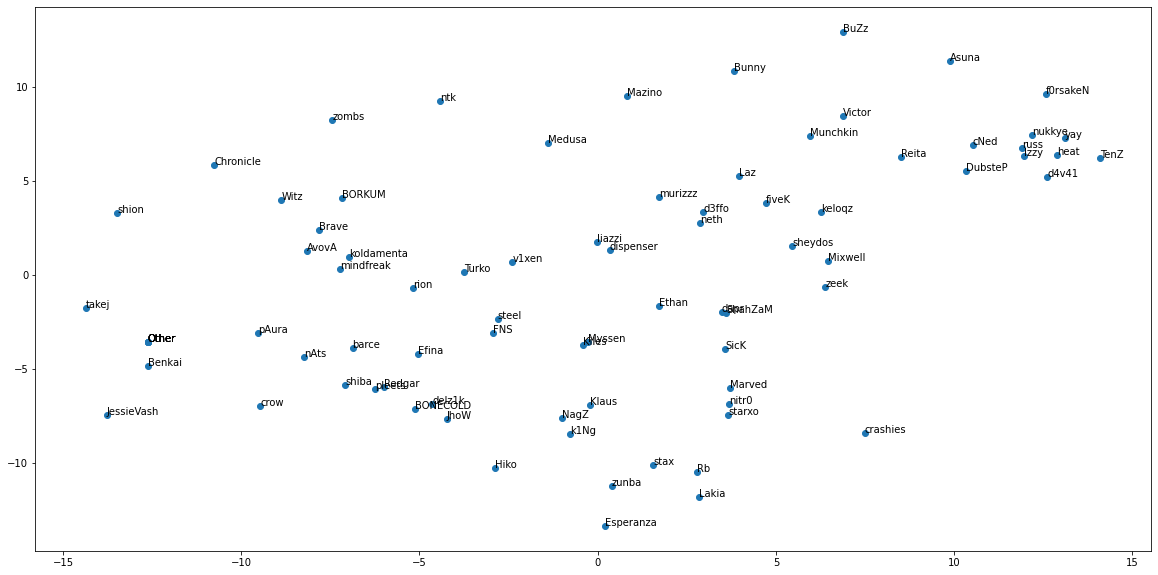

In [ ]:
#@title Embedding Visualization

from sklearn.manifold import TSNE
player_embeds = TSNE(n_components=2).fit_transform(stats_model.player_embeddings.weight.detach().cpu().numpy())
player_embeds.shape

idxs = []
for team, players in BERLIN_TEAM_PLAYERS.items():
  idxs.extend([x[1] for x in players])

plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(player_embeds[idxs, 0], player_embeds[idxs, 1])

for pidx in idxs:
  player = stats_model.players.get(pidx, "Other")
  plt.annotate(player, (player_embeds[pidx, 0], player_embeds[pidx, 1]))

# for player, idx in stats_model.players_map.items():
#   plt.annotate(player, (player_embeds[idx, 0], player_embeds[idx, 1]))

figpath = f"{PATH}/figs/embeddings_all.png"
plt.savefig(figpath)